In [30]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Dropout, Lambda, LSTM, GRU, Bidirectional, Layer, Attention, Activation, Flatten, GlobalMaxPooling1D
from keras_self_attention import SeqSelfAttention
from keras.utils.generic_utils import get_custom_objects
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from math import sin
from scipy.linalg import expm

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Customers_in_a_Shop.csv', header=None)
df.head()

,0,1
0,1949-01,114.0
1,1949-02,120.0
2,1949-03,134.0
3,1949-04,67.0
4,1949-05,123.0


In [3]:
df.columns={"Date","Customers"}
print(df.isnull().sum())

Date         0
Customers    4
dtype: int64


In [4]:
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m")
df = df.set_index('Date')
df

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,720.0


In [5]:
missing = df[df.isna().any(axis=1)]
print(missing)

            Customers
Date                 
1951-06-01        NaN
1951-07-01        NaN
1954-06-01        NaN
1960-03-01        NaN


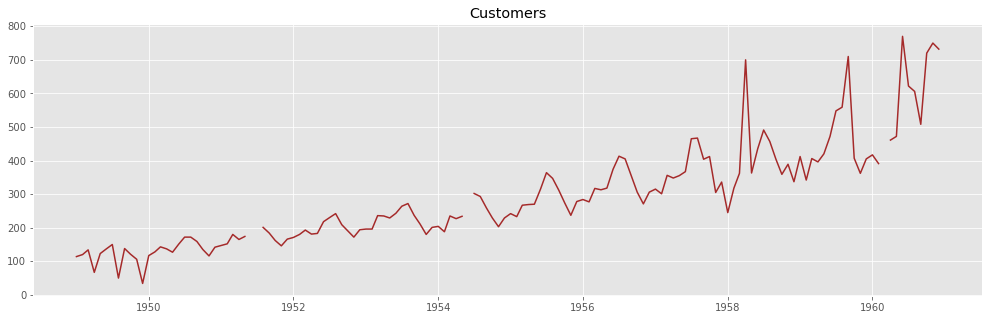

In [6]:
#from matplotlib import style
#print(plt.style.available)

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(17,5)

plt.plot(df, color='brown')
plt.title("Customers")
plt.show()

## Imputing missing values

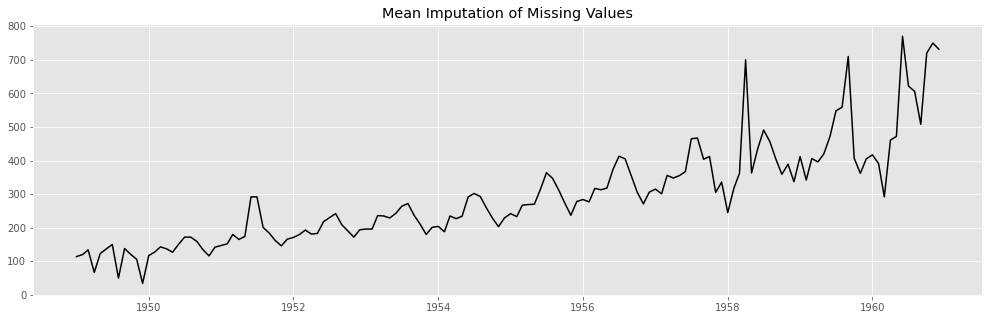

In [7]:
## Comparing several types of interpolations - mean 
plt.rcParams['figure.figsize']=(17,5)
df['Customers_mean'] = df['Customers'].fillna(df['Customers'].mean())
plt.plot(df['Customers_mean'],color='black')
plt.title("Mean Imputation of Missing Values")
plt.show()

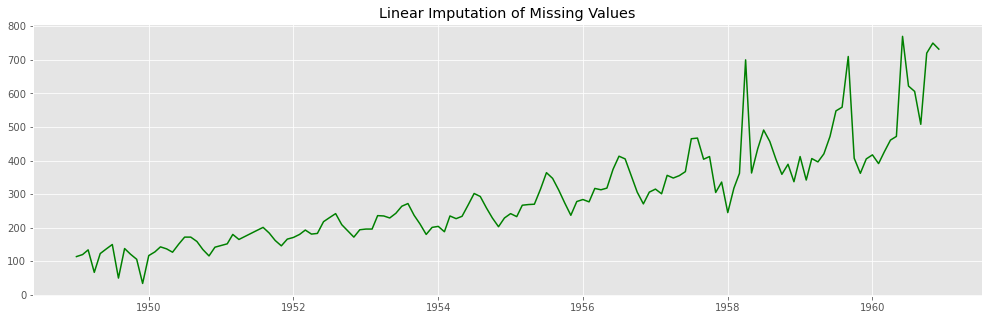

In [8]:
## Comparing several types of interpolations - linear
plt.rcParams['figure.figsize']=(17,5)
df['Customers_linear'] = df['Customers'].interpolate(method='linear')
plt.plot(df['Customers_linear'],color='green')
plt.title("Linear Imputation of Missing Values")
plt.show()

In [9]:
df1 = df['1949-06':'1960-06':12]
df1

,Customers,Customers_mean,Customers_linear
Date,,,
1949-06-01,137.0,137.000000,137.0
1950-06-01,151.0,151.000000,151.0
1951-06-01,NaN,291.878571,183.0
1952-06-01,218.0,218.000000,218.0
1953-06-01,243.0,243.000000,243.0
1954-06-01,NaN,291.878571,268.0
1955-06-01,315.0,315.000000,315.0
1956-06-01,374.0,374.000000,374.0
1957-06-01,367.0,367.000000,367.0


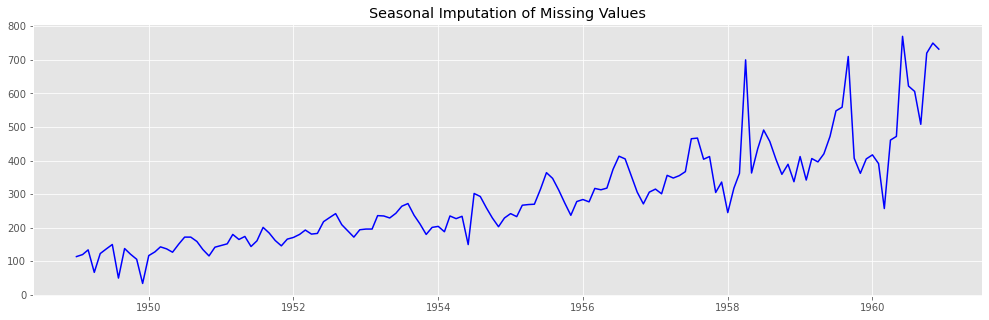

In [10]:
## Comparing several types of interpolations - seasonal interpolation
df.loc['1960-03'].fillna((df['1949-03':'1959-03':12].sum())/df['1949-03':'1959-03':12].shape[0], inplace=True)
df.loc['1954-06'].fillna((df['1949-06':'1953-06':12].sum())/(df['1949-06':'1953-06':12].shape[0]), inplace=True)
df.loc['1951-07'].fillna((df['1949-07':'1950-07':12].sum())/(df.loc['1949-07':'1950-07':12].shape[0]), inplace=True)
df.loc['1951-06'].fillna((df['1949-06':'1950-06':12].sum())/(df['1949-06':'1950-06':12].shape[0]), inplace=True)

plt.rcParams['figure.figsize']=(17,5)
plt.plot(df['Customers'],color='blue')
plt.title("Seasonal Imputation of Missing Values")
plt.show()

In [11]:
df['Customers'].sort_values(ascending=False).head(7)

Date
1960-06-01    770.0
1960-11-01    750.0
1960-12-01    732.0
1960-10-01    720.0
1959-09-01    710.0
1958-04-01    700.0
1960-07-01    622.0
Name: Customers, dtype: float64

## Normality plots 

/home/ardavan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Customers', ylabel='Density'>

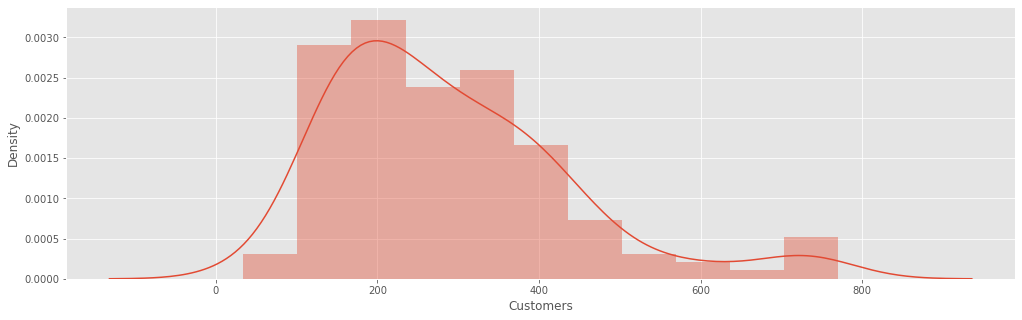

In [12]:
sns.distplot(df['Customers'])

((array([-2.58977345, -2.26833208, -2.08397164, -1.95134078, -1.84615093,
         -1.75813779, -1.68195358, -1.61444188, -1.55357684, -1.49797725,
         -1.44665728, -1.39888755, -1.35411252, -1.31189888, -1.27190175,
         -1.23384196, -1.19749012, -1.16265539, -1.12917712, -1.09691879,
         -1.06576327, -1.03560932, -1.00636876, -0.97796428, -0.95032771,
         -0.92339857, -0.89712296, -0.87145259, -0.84634402, -0.82175802,
         -0.797659  , -0.77401457, -0.75079515, -0.72797364, -0.70552513,
         -0.68342667, -0.66165704, -0.64019656, -0.61902697, -0.59813124,
         -0.57749349, -0.55709882, -0.53693331, -0.51698381, -0.49723799,
         -0.47768418, -0.45831134, -0.43910901, -0.42006725, -0.40117661,
         -0.38242807, -0.36381301, -0.34532319, -0.32695068, -0.30868788,
         -0.29052747, -0.27246238, -0.25448578, -0.23659106, -0.21877178,
         -0.2010217 , -0.18333474, -0.16570495, -0.14812651, -0.13059373,
         -0.11310101, -0.09564283, -0.

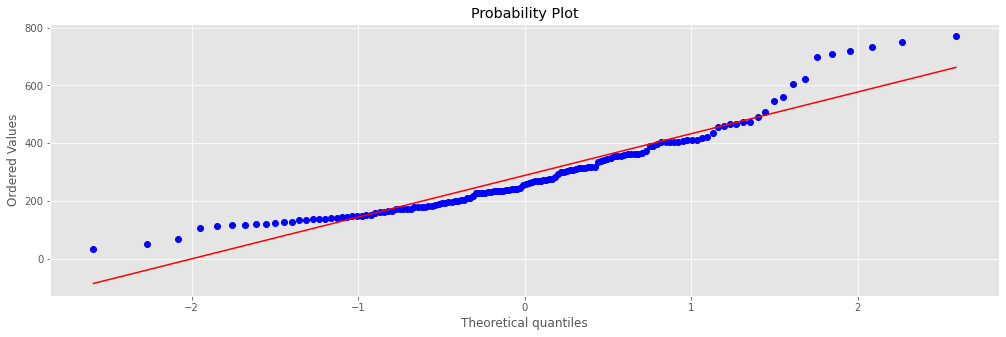

In [13]:
import scipy.stats
import pylab 
scipy.stats.probplot(df['Customers'],plot=pylab)
# pylab.show()

# Y-Axis: Data Value
# X-Axis: 

# Naive Decomposition
### Additive Seasonal Decomposition

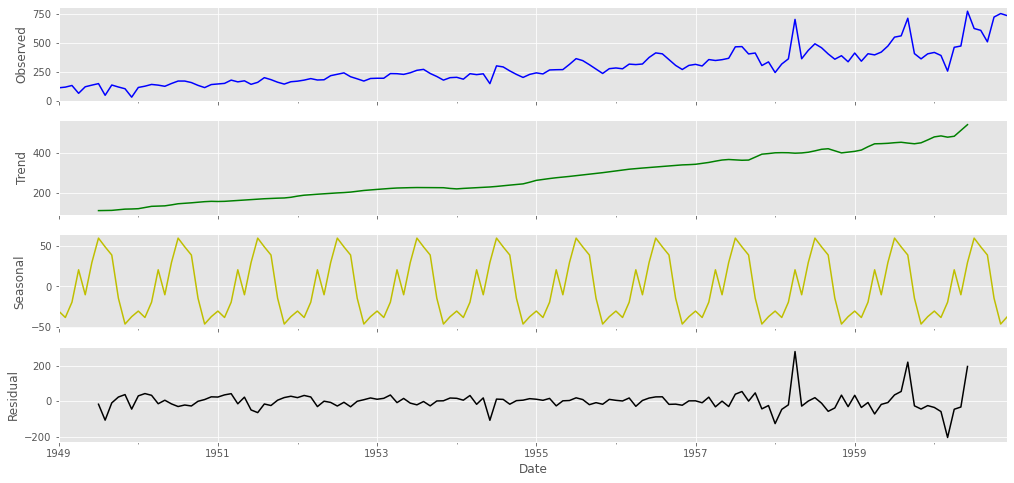

In [14]:
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='additive')
#decomposition.plot()

fig, axes = plt.subplots(4, 1, sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False, color='b')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, color='y')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')                           
plt.show()

### Multiplicative Seasonal Decomposition

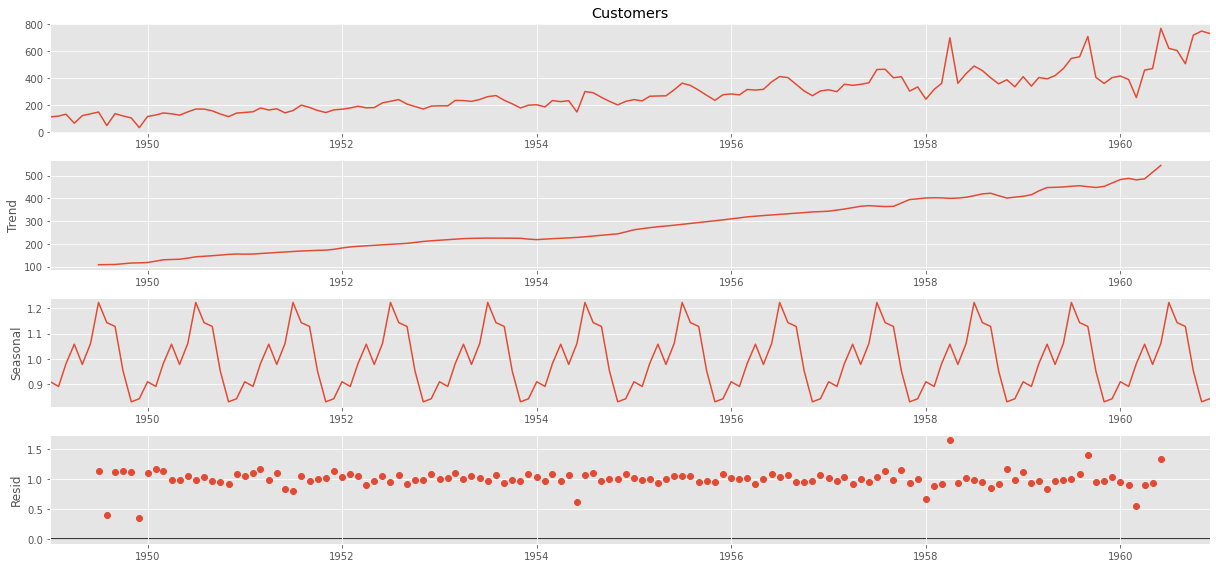

In [15]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Splitting Train and Test data

In [16]:
length = int(np.round(len(df["Customers_linear"])*0.8))
print(length)

115


In [17]:
df.drop(columns=["Customers_mean","Customers_linear"], inplace=True)
df.index.freq = 'MS'

In [18]:
## iF removing of the index is needed.
#df.reset_index(drop=True, inplace=True)
#df

In [19]:
train = df.iloc[:length,:]
train

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1958-03-01,362.0
1958-04-01,700.0
1958-05-01,363.0


In [20]:
test = df.iloc[length:,: ]
test

,Customers
Date,
1958-08-01,457.000000
1958-09-01,404.000000
1958-10-01,359.000000
1958-11-01,389.000000
1958-12-01,337.000000
1959-01-01,412.000000
1959-02-01,342.000000
1959-03-01,406.000000
1959-04-01,396.000000


In [21]:
print(test.shape)
print(train.shape)

(29, 1)
(115, 1)


In [22]:
SC = StandardScaler()
train = SC.fit_transform(train)
test = SC.transform(test)
train

array([[-1.21245702],
       [-1.15425422],
       [-1.0184477 ],
       [-1.66837891],
       [-1.12515282],
       [-0.9893463 ],
       [-0.86324024],
       [-1.83328683],
       [-0.97964583],
       [-1.14455375],
       [-1.29006074],
       [-1.98849429],
       [-1.18335562],
       [-1.07665049],
       [-0.9311435 ],
       [-0.9893463 ],
       [-1.08635096],
       [-0.85353978],
       [-0.64982999],
       [-0.64982999],
       [-0.77593605],
       [-1.00874723],
       [-1.19305608],
       [-0.94084397],
       [-0.89234164],
       [-0.84383931],
       [-0.57222627],
       [-0.71773325],
       [-0.63042906],
       [-0.92144304],
       [-0.75653512],
       [-0.36851648],
       [-0.5334244 ],
       [-0.74683465],
       [-0.90204211],
       [-0.70803279],
       [-0.65953046],
       [-0.57222627],
       [-0.44612021],
       [-0.5625258 ],
       [-0.54312487],
       [-0.20360856],
       [-0.08720297],
       [ 0.02920262],
       [-0.29091276],
       [-0

### Change Data to RNN Architecture

In [23]:
stepsize = 18 #Should be optimized!

def RNN_Structure(df, stepsize):
    X =[]
    Y =[]
    
    for n in range(len(df) - stepsize):
        z = n + stepsize
        X.append(df[n:z,]) #sample =10
        Y.append(df[z,])   #sample = 11 is your label
        
    return np.array(X) , np.array(Y)

        
X_train ,Y_train =  RNN_Structure(train, stepsize)
X_test  , Y_test =  RNN_Structure(test, stepsize)

In [24]:
print(X_train.shape) # X_train value with step = 10
print(X_test.shape)  # X_Test value with step = 10
print(Y_train.shape) # X_train value with step = 10
print(Y_test.shape)  # X_Test value with step = 10

(97, 18, 1)
(11, 18, 1)
(97, 1)
(11, 1)


* First Argument: Sample size
* Second Argument: Time Step
* Third Argument: Number of Feature

**(Sample size, Step Lenght/Sequence Lenght, Number of Input Feature/ Input Value to RNN)**

In [25]:
## Not necessary for this series, since already done in the previous definition function. But in case:

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_train.shape)
# print(X_test.shape)

In [26]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

### Simple RNN

In [172]:
def bern_sigm(x):
    bias1 = K.random_bernoulli(shape=[1])
    return K.sigmoid(x) + K.bias_add(x, bias1)
get_custom_objects().update({'bern_sigm': Activation(bern_sigm)})

In [234]:
RNN = Sequential()
RNN.add(SimpleRNN(units=512, return_sequences=False, activation = "relu"))
RNN.add(Dense(1, activation="bern_sigm"))
RNN.compile(loss ="mse", optimizer = "nadam", metrics="logcosh")

In [235]:
memory = RNN.fit(X_train, Y_train, epochs = 500, batch_size = 20, use_multiprocessing=True) 

Epoch 1/500
5/5 [==============================] - 1s 11ms/step - loss: 0.6271 - logcosh: 0.2372
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 0.3465 - logcosh: 0.1207
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.3109 - logcosh: 0.1154
Epoch 4/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2560 - logcosh: 0.0938
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2359 - logcosh: 0.0860
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2317 - logcosh: 0.0873
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2268 - logcosh: 0.0827
Epoch 8/500
5/5 [==============================] - 0s 11ms/step - loss: 0.1945 - logcosh: 0.0725
Epoch 9/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2360 - logcosh: 0.0949
Epoch 10/500
5/5 [==============================] - 0s 11ms/step - loss: 0.2184 - logcosh: 0.0888
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 11ms/step - loss: 0.0060 - logcosh: 0.0030
Epoch 84/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0053 - logcosh: 0.0026
Epoch 85/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0044 - logcosh: 0.0022
Epoch 86/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0089 - logcosh: 0.0043
Epoch 87/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0121 - logcosh: 0.0059
Epoch 88/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0066 - logcosh: 0.0033
Epoch 89/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0034 - logcosh: 0.0017
Epoch 90/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0058 - logcosh: 0.0028
Epoch 91/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0028 - logcosh: 0.0014
Epoch 92/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0054 - logcosh: 0.0027
Epoch 93/500
5/5 [===============

5/5 [==============================] - 0s 11ms/step - loss: 0.0047 - logcosh: 0.0024
Epoch 165/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0030 - logcosh: 0.0015
Epoch 166/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0028 - logcosh: 0.0014
Epoch 167/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0020 - logcosh: 0.0010
Epoch 168/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0016 - logcosh: 8.1077e-04
Epoch 169/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0012 - logcosh: 5.8486e-04
Epoch 170/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0012 - logcosh: 5.7298e-04
Epoch 171/500
5/5 [==============================] - 0s 12ms/step - loss: 8.4124e-04 - logcosh: 4.1917e-04
Epoch 172/500
5/5 [==============================] - 0s 12ms/step - loss: 5.9194e-04 - logcosh: 2.9534e-04
Epoch 173/500
5/5 [==============================] - 0s 13ms/step - loss: 4.3584e-04 - logcosh:

5/5 [==============================] - 0s 11ms/step - loss: 3.4560e-04 - logcosh: 1.7272e-04
Epoch 242/500
5/5 [==============================] - 0s 11ms/step - loss: 3.0506e-04 - logcosh: 1.5237e-04
Epoch 243/500
5/5 [==============================] - 0s 10ms/step - loss: 3.0505e-04 - logcosh: 1.5229e-04
Epoch 244/500
5/5 [==============================] - 0s 12ms/step - loss: 3.1409e-04 - logcosh: 1.5686e-04
Epoch 245/500
5/5 [==============================] - 0s 11ms/step - loss: 3.3900e-04 - logcosh: 1.6931e-04
Epoch 246/500
5/5 [==============================] - 0s 11ms/step - loss: 2.9606e-04 - logcosh: 1.4796e-04
Epoch 247/500
5/5 [==============================] - 0s 11ms/step - loss: 1.7775e-04 - logcosh: 8.8855e-05
Epoch 248/500
5/5 [==============================] - 0s 12ms/step - loss: 2.7996e-04 - logcosh: 1.3993e-04
Epoch 249/500
5/5 [==============================] - 0s 11ms/step - loss: 2.5448e-04 - logcosh: 1.2719e-04
Epoch 250/500
5/5 [==============================] 

5/5 [==============================] - 0s 12ms/step - loss: 5.8855e-04 - logcosh: 2.9353e-04
Epoch 319/500
5/5 [==============================] - 0s 12ms/step - loss: 6.5224e-04 - logcosh: 3.2519e-04
Epoch 320/500
5/5 [==============================] - 0s 11ms/step - loss: 8.9688e-04 - logcosh: 4.4635e-04
Epoch 321/500
5/5 [==============================] - 0s 12ms/step - loss: 7.8171e-04 - logcosh: 3.8945e-04
Epoch 322/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - logcosh: 5.6086e-04
Epoch 323/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0012 - logcosh: 5.9037e-04
Epoch 324/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0020 - logcosh: 0.0010   
Epoch 325/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0019 - logcosh: 9.3415e-04
Epoch 326/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0091 - logcosh: 0.0045   
Epoch 327/500
5/5 [==============================] - 0s 11ms/step - loss:

5/5 [==============================] - 0s 12ms/step - loss: 1.3250e-04 - logcosh: 6.6219e-05
Epoch 396/500
5/5 [==============================] - 0s 11ms/step - loss: 1.9013e-04 - logcosh: 9.5021e-05
Epoch 397/500
5/5 [==============================] - 0s 11ms/step - loss: 1.8024e-04 - logcosh: 9.0072e-05
Epoch 398/500
5/5 [==============================] - 0s 11ms/step - loss: 2.1354e-04 - logcosh: 1.0672e-04
Epoch 399/500
5/5 [==============================] - 0s 11ms/step - loss: 2.5542e-04 - logcosh: 1.2765e-04
Epoch 400/500
5/5 [==============================] - 0s 11ms/step - loss: 3.8231e-04 - logcosh: 1.9104e-04
Epoch 401/500
5/5 [==============================] - 0s 11ms/step - loss: 3.2897e-04 - logcosh: 1.6440e-04
Epoch 402/500
5/5 [==============================] - 0s 11ms/step - loss: 3.9055e-04 - logcosh: 1.9512e-04
Epoch 403/500
5/5 [==============================] - 0s 11ms/step - loss: 4.0198e-04 - logcosh: 2.0092e-04
Epoch 404/500
5/5 [==============================] 

5/5 [==============================] - 0s 12ms/step - loss: 1.8224e-05 - logcosh: 9.1085e-06
Epoch 473/500
5/5 [==============================] - 0s 12ms/step - loss: 2.1858e-05 - logcosh: 1.0929e-05
Epoch 474/500
5/5 [==============================] - 0s 11ms/step - loss: 2.0737e-05 - logcosh: 1.0367e-05
Epoch 475/500
5/5 [==============================] - 0s 12ms/step - loss: 1.4664e-05 - logcosh: 7.3424e-06
Epoch 476/500
5/5 [==============================] - 0s 11ms/step - loss: 1.7808e-05 - logcosh: 8.9063e-06
Epoch 477/500
5/5 [==============================] - 0s 11ms/step - loss: 2.4337e-05 - logcosh: 1.2166e-05
Epoch 478/500
5/5 [==============================] - 0s 11ms/step - loss: 2.6062e-05 - logcosh: 1.3029e-05
Epoch 479/500
5/5 [==============================] - 0s 11ms/step - loss: 2.8394e-05 - logcosh: 1.4197e-05
Epoch 480/500
5/5 [==============================] - 0s 11ms/step - loss: 2.6177e-05 - logcosh: 1.3087e-05
Epoch 481/500
5/5 [==============================] 

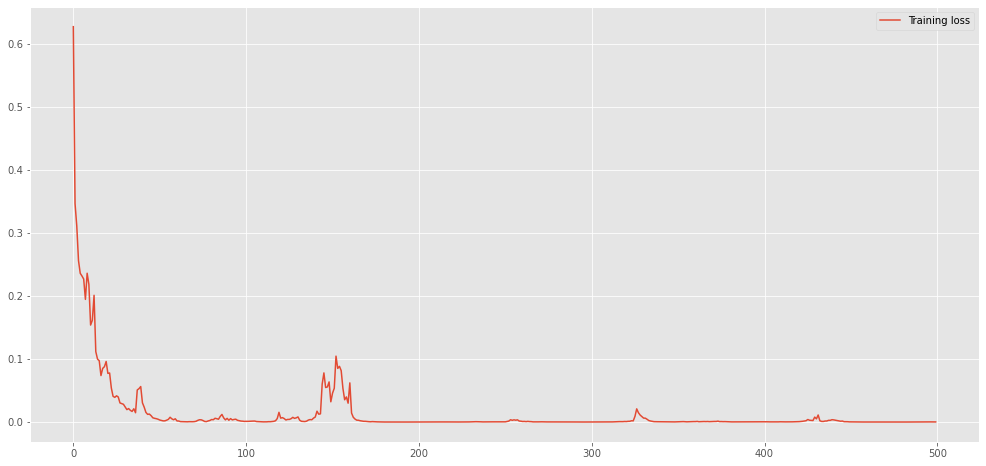

In [236]:
Loss_func = memory.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [237]:
RNN.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_97 (SimpleRNN)    (None, 512)               263168    
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 513       
Total params: 263,681
Trainable params: 263,681
Non-trainable params: 0
_________________________________________________________________


In [238]:
score = RNN.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh

[8.15700987004675e-05, 4.0780636481940746e-05]

In [239]:
#X_train = np.reshape(X_train, (-1,1))
#X_test = np.reshape(X_test, (-1,1))
print(X_train.shape)
print(X_test.shape)

(97, 18, 1)
(11, 18, 1)


In [240]:
pred_train = SC.inverse_transform(RNN.predict(X_train))
pred_test = SC.inverse_transform(RNN.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [241]:
pred

,0
0,170.943176
1,171.477936
2,157.329285
3,134.883026
4,114.952728
...,...
103,621.125366
104,581.937866
105,346.708954
106,610.510803


In [242]:
df.reset_index(inplace=True, drop=True)
df

,Customers
0,114.0
1,120.0
2,134.0
3,67.0
4,123.0
...,...
139,606.0
140,508.0
141,720.0
142,750.0


<function matplotlib.pyplot.show(close=None, block=None)>

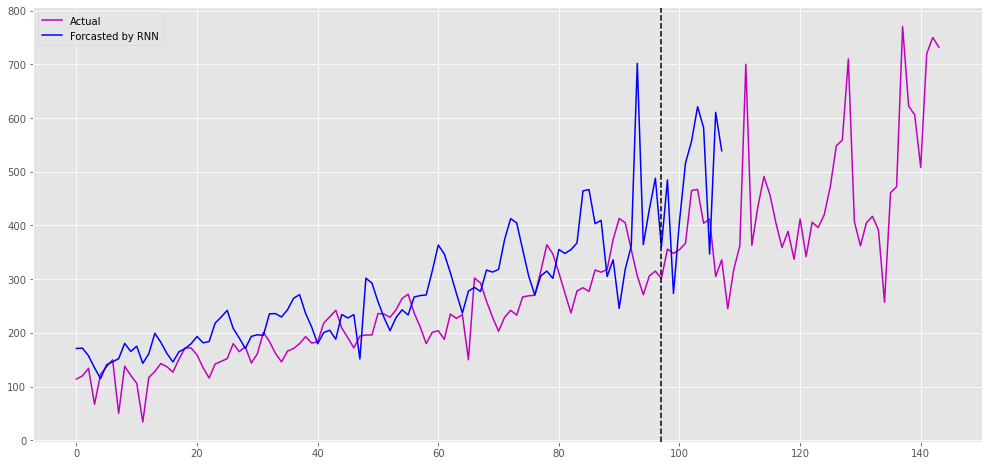

In [243]:
plt.plot(df, color="m")
plt.plot(pred, color="blue")
plt.legend(["Actual","Forcasted by RNN"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### Long-Short Term Memory (LSTM)

In [205]:
lstm = Sequential()
lstm.add(LSTM(units=512, return_sequences=False, activation ="selu"))
lstm.add(Dense(1, activation="bern_sigm"))
lstm.compile(loss ="mse", optimizer='nadam', metrics="logcosh")
memory_lstm = lstm.fit(X_train, Y_train , epochs = 250, batch_size = 20, verbose = 1)

Epoch 1/250
5/5 [==============================] - 1s 44ms/step - loss: 0.8110 - logcosh: 0.3023
Epoch 2/250
5/5 [==============================] - 0s 43ms/step - loss: 0.2970 - logcosh: 0.1089
Epoch 3/250
5/5 [==============================] - 0s 43ms/step - loss: 0.2690 - logcosh: 0.1044
Epoch 4/250
5/5 [==============================] - 0s 43ms/step - loss: 0.2849 - logcosh: 0.1122
Epoch 5/250
5/5 [==============================] - 0s 44ms/step - loss: 0.2159 - logcosh: 0.0823
Epoch 6/250
5/5 [==============================] - 0s 44ms/step - loss: 0.2090 - logcosh: 0.0773
Epoch 7/250
5/5 [==============================] - 0s 44ms/step - loss: 0.2066 - logcosh: 0.0769
Epoch 8/250
5/5 [==============================] - 0s 45ms/step - loss: 0.3024 - logcosh: 0.1202
Epoch 9/250
5/5 [==============================] - 0s 47ms/step - loss: 0.2373 - logcosh: 0.0924
Epoch 10/250
5/5 [==============================] - 0s 46ms/step - loss: 0.2388 - logcosh: 0.0915
Epoch 11/250
5/5 [===========

5/5 [==============================] - 0s 45ms/step - loss: 0.0590 - logcosh: 0.0275
Epoch 85/250
5/5 [==============================] - 0s 41ms/step - loss: 0.0727 - logcosh: 0.0344
Epoch 86/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0859 - logcosh: 0.0383
Epoch 87/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0571 - logcosh: 0.0272
Epoch 88/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0579 - logcosh: 0.0275
Epoch 89/250
5/5 [==============================] - 0s 43ms/step - loss: 0.0843 - logcosh: 0.0372
Epoch 90/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0582 - logcosh: 0.0280
Epoch 91/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0663 - logcosh: 0.0306
Epoch 92/250
5/5 [==============================] - 0s 43ms/step - loss: 0.0452 - logcosh: 0.0215
Epoch 93/250
5/5 [==============================] - 0s 42ms/step - loss: 0.0556 - logcosh: 0.0262
Epoch 94/250
5/5 [===============

5/5 [==============================] - 0s 42ms/step - loss: 0.2165 - logcosh: 0.0804
Epoch 168/250
5/5 [==============================] - 0s 43ms/step - loss: 0.1980 - logcosh: 0.0741
Epoch 169/250
5/5 [==============================] - 0s 43ms/step - loss: 0.2128 - logcosh: 0.0858
Epoch 170/250
5/5 [==============================] - 0s 42ms/step - loss: 0.1906 - logcosh: 0.0737
Epoch 171/250
5/5 [==============================] - 0s 42ms/step - loss: 0.1697 - logcosh: 0.0655
Epoch 172/250
5/5 [==============================] - 0s 43ms/step - loss: 0.1489 - logcosh: 0.0579
Epoch 173/250
5/5 [==============================] - 0s 47ms/step - loss: 0.2030 - logcosh: 0.0862
Epoch 174/250
5/5 [==============================] - 0s 42ms/step - loss: 0.1742 - logcosh: 0.0623
Epoch 175/250
5/5 [==============================] - 0s 43ms/step - loss: 0.1845 - logcosh: 0.0715
Epoch 176/250
5/5 [==============================] - 0s 43ms/step - loss: 0.1934 - logcosh: 0.0692
Epoch 177/250
5/5 [=====

5/5 [==============================] - 0s 42ms/step - loss: 0.0192 - logcosh: 0.0095
Epoch 250/250
5/5 [==============================] - 0s 43ms/step - loss: 0.0199 - logcosh: 0.0098


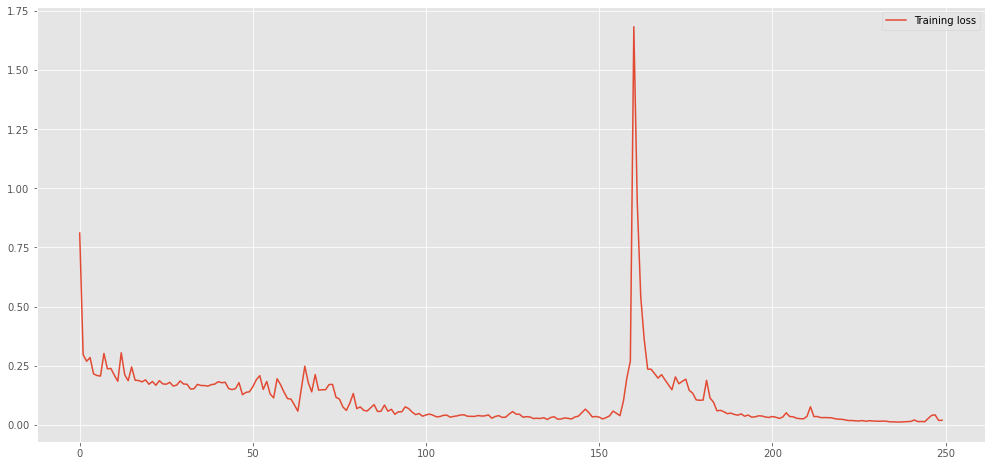

In [206]:
Loss_func = memory_lstm.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [207]:
pred_train = SC.inverse_transform(lstm.predict(X_train))
pred_test = SC.inverse_transform(lstm.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [208]:
lstm.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512)               1052672   
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [209]:
score = lstm.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh                  #Question: Why is the RNN's performance better than LSTM?!

[0.0361519493162632, 0.017778517678380013]

<function matplotlib.pyplot.show(close=None, block=None)>

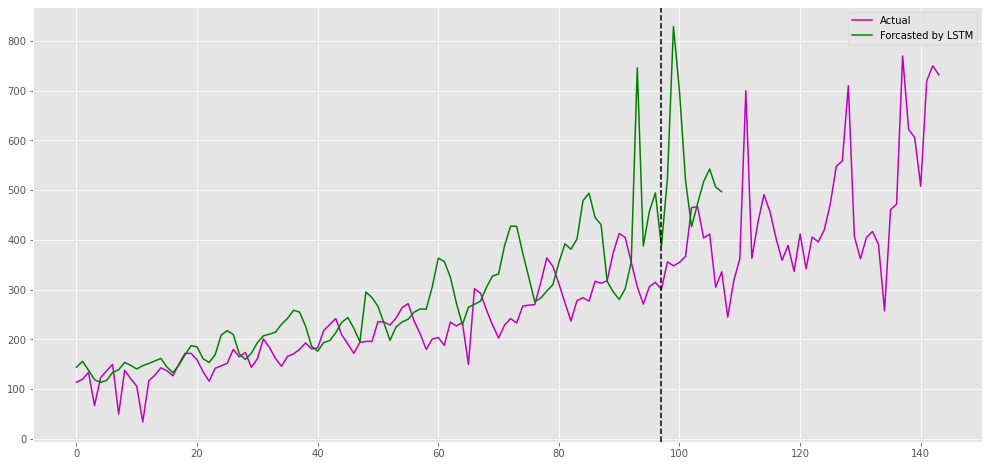

In [210]:
plt.plot(df, color="m")
plt.plot(pred, color="green")
plt.legend(["Actual","Forcasted by LSTM"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show #RNN still works better compared with LSTM even with the attention layer! (Why?)

### Bi-LSTM

In [211]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(units=512, return_sequences=False, activation ="relu")))
bilstm.add(Dense(1, activation="bern_sigm"))
bilstm.compile(loss ="mse", optimizer='nadam', metrics="logcosh")
memory_bilstm = bilstm.fit(X_train, Y_train , epochs = 250, batch_size = 20, verbose = 1)

Epoch 1/250
5/5 [==============================] - 2s 76ms/step - loss: 0.5248 - logcosh: 0.2013
Epoch 2/250
5/5 [==============================] - 0s 79ms/step - loss: 0.3221 - logcosh: 0.1189
Epoch 3/250
5/5 [==============================] - 0s 78ms/step - loss: 0.2485 - logcosh: 0.0938
Epoch 4/250
5/5 [==============================] - 0s 80ms/step - loss: 0.3132 - logcosh: 0.1182
Epoch 5/250
5/5 [==============================] - 0s 78ms/step - loss: 0.2761 - logcosh: 0.1022
Epoch 6/250
5/5 [==============================] - 0s 77ms/step - loss: 0.2669 - logcosh: 0.0984
Epoch 7/250
5/5 [==============================] - 0s 79ms/step - loss: 0.2513 - logcosh: 0.0935
Epoch 8/250
5/5 [==============================] - 0s 80ms/step - loss: 0.2320 - logcosh: 0.0834
Epoch 9/250
5/5 [==============================] - 0s 89ms/step - loss: 0.3604 - logcosh: 0.1299
Epoch 10/250
5/5 [==============================] - 0s 79ms/step - loss: 0.2574 - logcosh: 0.0957
Epoch 11/250
5/5 [===========

5/5 [==============================] - 0s 78ms/step - loss: 0.1554 - logcosh: 0.0608
Epoch 85/250
5/5 [==============================] - 0s 78ms/step - loss: 0.1341 - logcosh: 0.0553
Epoch 86/250
5/5 [==============================] - 0s 77ms/step - loss: 0.1142 - logcosh: 0.0467
Epoch 87/250
5/5 [==============================] - 0s 77ms/step - loss: 0.1314 - logcosh: 0.0523
Epoch 88/250
5/5 [==============================] - 0s 79ms/step - loss: 0.1204 - logcosh: 0.0477
Epoch 89/250
5/5 [==============================] - 0s 77ms/step - loss: 0.1449 - logcosh: 0.0535
Epoch 90/250
5/5 [==============================] - 0s 77ms/step - loss: 0.1156 - logcosh: 0.0471
Epoch 91/250
5/5 [==============================] - 0s 77ms/step - loss: 0.1104 - logcosh: 0.0438
Epoch 92/250
5/5 [==============================] - 0s 77ms/step - loss: 0.0964 - logcosh: 0.0421
Epoch 93/250
5/5 [==============================] - 0s 78ms/step - loss: 0.1449 - logcosh: 0.0631
Epoch 94/250
5/5 [===============

5/5 [==============================] - 0s 78ms/step - loss: 0.0210 - logcosh: 0.0103
Epoch 168/250
5/5 [==============================] - 0s 78ms/step - loss: 0.0146 - logcosh: 0.0072
Epoch 169/250
5/5 [==============================] - 0s 77ms/step - loss: 0.0155 - logcosh: 0.0077
Epoch 170/250
5/5 [==============================] - 0s 79ms/step - loss: 0.0197 - logcosh: 0.0097
Epoch 171/250
5/5 [==============================] - 0s 77ms/step - loss: 0.0162 - logcosh: 0.0080
Epoch 172/250
5/5 [==============================] - 0s 77ms/step - loss: 0.0159 - logcosh: 0.0079
Epoch 173/250
5/5 [==============================] - 0s 78ms/step - loss: 0.0132 - logcosh: 0.0066
Epoch 174/250
5/5 [==============================] - 0s 77ms/step - loss: 0.0161 - logcosh: 0.0079
Epoch 175/250
5/5 [==============================] - 0s 78ms/step - loss: 0.0155 - logcosh: 0.0077
Epoch 176/250
5/5 [==============================] - 0s 78ms/step - loss: 0.0141 - logcosh: 0.0070
Epoch 177/250
5/5 [=====

5/5 [==============================] - 0s 81ms/step - loss: 0.0037 - logcosh: 0.0019
Epoch 250/250
5/5 [==============================] - 0s 79ms/step - loss: 0.0034 - logcosh: 0.0017


In [212]:
pred_train = SC.inverse_transform(bilstm.predict(X_train))
pred_test = SC.inverse_transform(bilstm.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

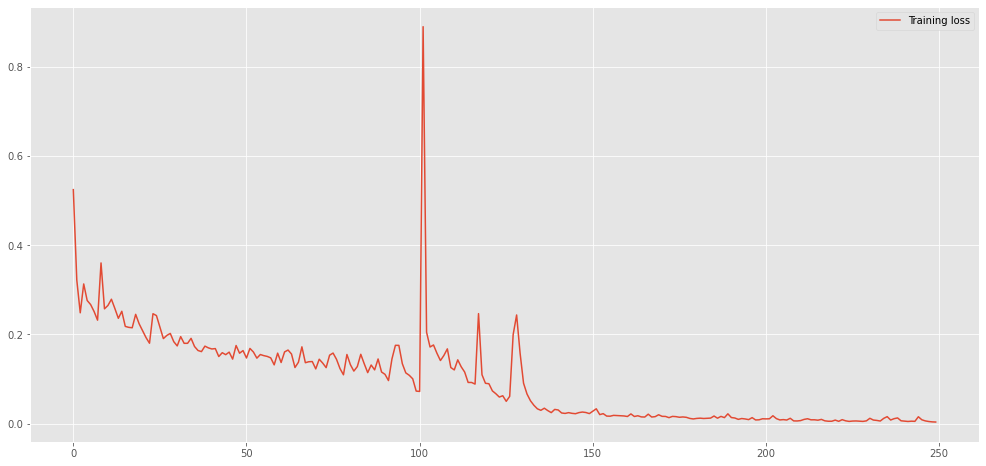

In [213]:
Loss_func = memory_bilstm.history["loss"] 
plt.plot(Loss_func, label= "Training loss")
plt.legend() # People may argue why I have schosen 1000 iterations, but the following diagram is self-descriptive!

In [214]:
bilstm.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1024)              2105344   
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 1025      
Total params: 2,106,369
Trainable params: 2,106,369
Non-trainable params: 0
_________________________________________________________________


In [215]:
score = bilstm.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh 

[0.0037671250756829977, 0.0018785485299304128]

<function matplotlib.pyplot.show(close=None, block=None)>

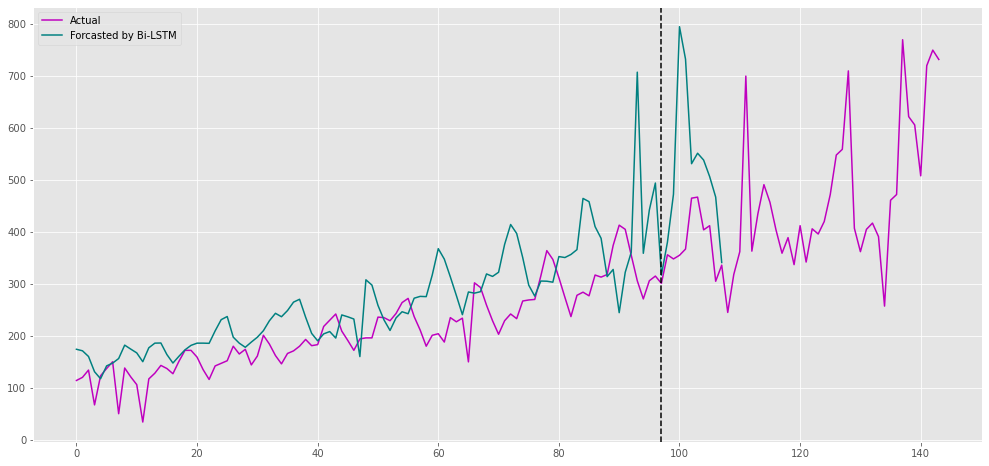

In [216]:
plt.plot(df, color="m")
plt.plot(pred, color="teal")
plt.legend(["Actual","Forcasted by Bi-LSTM"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### Gated Recurrent Unit (GRU)

In [226]:
gru = Sequential()
gru.add(GRU(units=512, return_sequences=False, activation ="selu"))
gru.add(Dense(1, activation="bern_sigm"))
gru.compile(loss ="mse", optimizer='nadam', metrics="logcosh")
memory_gru = gru.fit(X_train, Y_train , epochs = 500, batch_size = 20, verbose = 1)

Epoch 1/500
5/5 [==============================] - 1s 33ms/step - loss: 0.4195 - logcosh: 0.1582
Epoch 2/500
5/5 [==============================] - 0s 31ms/step - loss: 0.5301 - logcosh: 0.1941
Epoch 3/500
5/5 [==============================] - 0s 31ms/step - loss: 0.3027 - logcosh: 0.1105
Epoch 4/500
5/5 [==============================] - 0s 31ms/step - loss: 0.3069 - logcosh: 0.1103
Epoch 5/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2755 - logcosh: 0.0990
Epoch 6/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2834 - logcosh: 0.1013
Epoch 7/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2662 - logcosh: 0.0962
Epoch 8/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2469 - logcosh: 0.0930
Epoch 9/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2387 - logcosh: 0.0892
Epoch 10/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2233 - logcosh: 0.0825
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 31ms/step - loss: 0.0495 - logcosh: 0.0234
Epoch 85/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0449 - logcosh: 0.0210
Epoch 86/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0429 - logcosh: 0.0205
Epoch 87/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0415 - logcosh: 0.0198
Epoch 88/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0402 - logcosh: 0.0192
Epoch 89/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0368 - logcosh: 0.0175
Epoch 90/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0377 - logcosh: 0.0178
Epoch 91/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0380 - logcosh: 0.0179
Epoch 92/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0364 - logcosh: 0.0174
Epoch 93/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0479 - logcosh: 0.0228
Epoch 94/500
5/5 [===============

5/5 [==============================] - 0s 32ms/step - loss: 0.0073 - logcosh: 0.0036
Epoch 168/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0067 - logcosh: 0.0033
Epoch 169/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0055 - logcosh: 0.0028
Epoch 170/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0059 - logcosh: 0.0029
Epoch 171/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0051 - logcosh: 0.0025
Epoch 172/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0051 - logcosh: 0.0025
Epoch 173/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0053 - logcosh: 0.0027
Epoch 174/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0051 - logcosh: 0.0026
Epoch 175/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0050 - logcosh: 0.0025
Epoch 176/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0044 - logcosh: 0.0022
Epoch 177/500
5/5 [=====

5/5 [==============================] - 0s 31ms/step - loss: 0.0083 - logcosh: 0.0041
Epoch 250/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0114 - logcosh: 0.0056
Epoch 251/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0272 - logcosh: 0.0133
Epoch 252/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0402 - logcosh: 0.0197
Epoch 253/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0172 - logcosh: 0.0084
Epoch 254/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0124 - logcosh: 0.0061
Epoch 255/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0070 - logcosh: 0.0035
Epoch 256/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0078 - logcosh: 0.0039
Epoch 257/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0305 - logcosh: 0.0149
Epoch 258/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0175 - logcosh: 0.0087
Epoch 259/500
5/5 [=====

Epoch 327/500
5/5 [==============================] - 0s 31ms/step - loss: 3.3794e-04 - logcosh: 1.6893e-04
Epoch 328/500
5/5 [==============================] - 0s 31ms/step - loss: 1.9669e-04 - logcosh: 9.8334e-05
Epoch 329/500
5/5 [==============================] - 0s 31ms/step - loss: 2.8387e-04 - logcosh: 1.4190e-04
Epoch 330/500
5/5 [==============================] - 0s 31ms/step - loss: 4.8520e-04 - logcosh: 2.4253e-04
Epoch 331/500
5/5 [==============================] - 0s 31ms/step - loss: 3.7161e-04 - logcosh: 1.8575e-04
Epoch 332/500
5/5 [==============================] - 0s 31ms/step - loss: 3.2785e-04 - logcosh: 1.6389e-04
Epoch 333/500
5/5 [==============================] - 0s 32ms/step - loss: 2.6625e-04 - logcosh: 1.3308e-04
Epoch 334/500
5/5 [==============================] - 0s 31ms/step - loss: 3.6451e-04 - logcosh: 1.8215e-04
Epoch 335/500
5/5 [==============================] - 0s 31ms/step - loss: 3.6887e-04 - logcosh: 1.8440e-04
Epoch 336/500
5/5 [==================

5/5 [==============================] - 0s 32ms/step - loss: 0.0122 - logcosh: 0.0060
Epoch 408/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0075 - logcosh: 0.0038
Epoch 409/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0091 - logcosh: 0.0045
Epoch 410/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0105 - logcosh: 0.0052
Epoch 411/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0133 - logcosh: 0.0066
Epoch 412/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0085 - logcosh: 0.0042
Epoch 413/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0068 - logcosh: 0.0034
Epoch 414/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0072 - logcosh: 0.0036
Epoch 415/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0056 - logcosh: 0.0028
Epoch 416/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0056 - logcosh: 0.0028
Epoch 417/500
5/5 [=====

5/5 [==============================] - 0s 31ms/step - loss: 7.1045e-04 - logcosh: 3.5504e-04
Epoch 487/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0011 - logcosh: 5.5813e-04
Epoch 488/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0015 - logcosh: 7.4447e-04
Epoch 489/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0010 - logcosh: 5.0408e-04
Epoch 490/500
5/5 [==============================] - 0s 31ms/step - loss: 5.2396e-04 - logcosh: 2.6180e-04
Epoch 491/500
5/5 [==============================] - 0s 31ms/step - loss: 3.6433e-04 - logcosh: 1.8208e-04
Epoch 492/500
5/5 [==============================] - 0s 31ms/step - loss: 2.0451e-04 - logcosh: 1.0224e-04
Epoch 493/500
5/5 [==============================] - 0s 31ms/step - loss: 1.6151e-04 - logcosh: 8.0747e-05
Epoch 494/500
5/5 [==============================] - 0s 31ms/step - loss: 1.5819e-04 - logcosh: 7.9089e-05
Epoch 495/500
5/5 [==============================] - 0s 31ms/st

In [227]:
pred_train = SC.inverse_transform(gru.predict(X_train))
pred_test = SC.inverse_transform(gru.predict(X_test))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

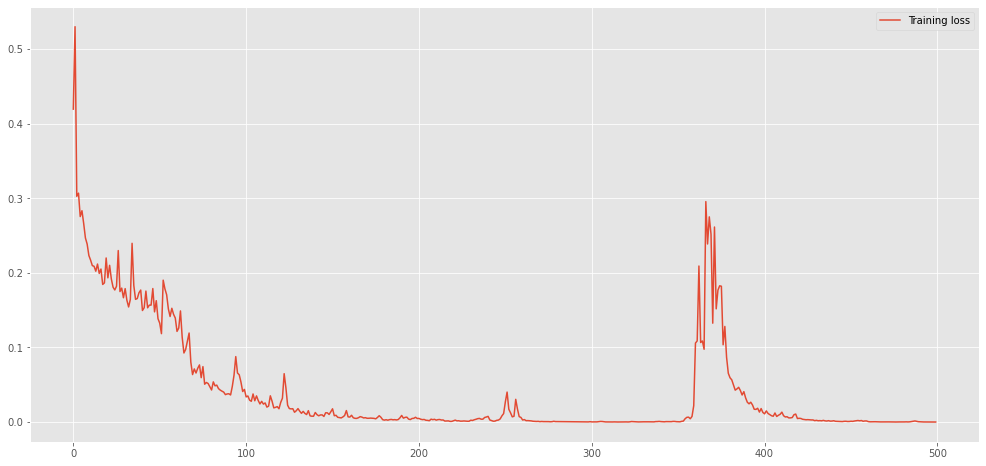

In [228]:
Loss_func = memory_gru.history["loss"] 
plt.plot(Loss_func, label= "Training loss")
plt.legend() 

In [229]:
gru.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 512)               791040    
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [230]:
score = gru.evaluate(X_train, Y_train, verbose = 0)
score #MSE Logcosh 

[0.00016736122779548168, 8.36695617181249e-05]

<function matplotlib.pyplot.show(close=None, block=None)>

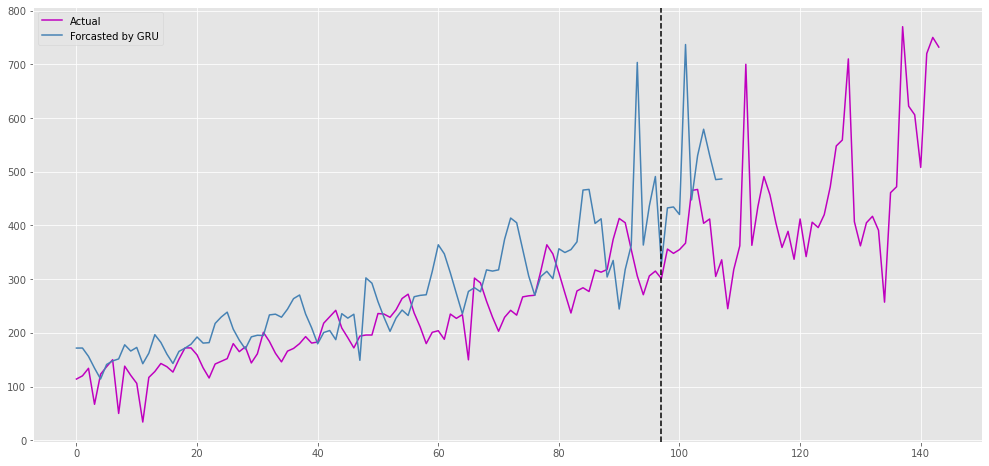

In [231]:
plt.plot(df, color="m")
plt.plot(pred, color="steelblue")
plt.legend(["Actual","Forcasted by GRU"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

### <font color='steelblue'> The defined sigmoid function with a bernoulli bias works even better than relu in all models. Note that removing the stacked layers of RNN improved the performance of all models with the exception of simple RNN.  </font>